In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

plt.style.use('seaborn')

from numpy.random import seed


from tensorflow.compat.v1 import set_random_seed


## Goal of This Notebook

About a year ago, I constructed a NN model using Swish Activation Function to solve a classification problem. At that time, I had no idea why I used that particular activation. I had seen the Swish Activation in another notebook. I had tested several times and seen the performance improvement, so I decided to implement it. 

Now I have more knowledge (at least compared to the before) about the concepts, so I decided to show people like me what actually is the Swish Activation and why do we use it. I  hope it will be helpful to the ones who are curious about this topic.

## The Inspiration

The experiment I have done is similar to the one found in [[1]](https://arxiv.org/abs/1710.05941).

## Brief Introduction

Activation functions are used for modeling nonlinear behaviours. They are put on various places on deep learning models. I have prepared a more detailed notebook previously about them. If you're not familiar with these concepts, you can check [here](https://www.kaggle.com/code/egemenuurdalg/deeper-look-at-activation-functions?scriptVersionId=102886039). 

ReLU is one of the better activation functions. Therefore, it is widely used. In this experiment we will test the new best candidates of activation functions in [[1]](https://arxiv.org/abs/1710.05941) and see whether any of them will be able to surpass the performance of ReLU.

**Properties of Good Activation Functions**

1. *Simple* : Complex activation functions are hard to optimize. Therefore, they constantly underperform.
2. *Use of raw preactivation*: All good candidates use input x directly in the mapping process.
3.*Use of periodic functions*: Good candidates use periodic activation functions like sin and cos
4.*Division error*: Functions containing division should only be used in caution. Otherwise they diverge around zero.

Note: ReLU checks point 1,2 and 4. It is not suprising that it is a good activation function. 

**Swish**

Swish  is a relatively new activation function which constantly outperforms ReLU [[2]](https://arxiv.org/pdf/1710.05941v1.pdf). It is: 

1. *Unbounded*: This is important because bounded activation functions cause Vanishing Gradient Problem near the saturation points due to small gradients.
2. *Smooth*: Smooth functions are easier to optimize because they are less sensitive to learning rate (step size) or initialization. On the other hand, when there is a sharpness in activation function, we have to select learning rate small because, otherwise after a certain point (abs(X_t) < eta), the algorithm constantly miss the global minima. ReLU outputs have a distinct sharpness. It outputs 0 for each negative point and input itself at each positive point. Conversely, Swish is smooth everywhere, which makes it easier to optimize.
3. *Bounded at negative values*: Swish, ReLU and SoftPlus are bounded at negative region. This  is good for regularizing the inputs. Negative inputs are forgotten (due to approaching to 0) and it is especially important at the start of the training process. Different from ReLU and Softplus, Swish outputs negative values for negative inputs. This increases it's expressivity and improves gradient flow. 

## Content

1. [Setting and Visualizing the Best Candidates](#1)
2. [Testing the Candidates on a Neural Network Model](#2)

## Preparation for the Experiment

In [2]:
def plot_histories(histories):
    fig,ax = plt.subplots(ncols = 2, figsize = (15,5))
    epochs = list(range(100))
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Training Steps')
    ax[0].set_title('Convolution Model Training Curve')

    ax[0].set_ylabel('Accuracy')
    ax[1].set_xlabel('Training Steps')
    ax[1].set_title('Convolution Model Validation Curve')
    for names,hist in zip(fnc_names,histories):
      training_accuracy = hist.history['accuracy']
      validation_accuracy = hist.history['val_accuracy']
      ax[0].plot(epochs, training_accuracy, label = names)
      ax[1].plot(epochs, validation_accuracy, label = names)

    ax[0].legend()
    ax[1].legend()
    fig.show()

def train_model(activation):
  model = keras.Sequential([
  layers.Rescaling(1./255, input_shape=(32, 32, 3)),
  layers.Conv2D(16, 3, padding='same', activation = activation),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation = activation),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation = activation),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation = activation),
  layers.Dense(10)
  ])
  model.compile(
  optimizer = 'sgd',
  metrics = ['accuracy'],
  loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True))
  history = model.fit(train_ds,validation_data = test_ds,epochs = 100, verbose = 0)
  return history

<a id='1'></a>
## 1. Setting and Visualizing the Best Candidates

* In this section, I defined and plotted the best activation functions found in [[1]](https://arxiv.org/abs/1710.05941). There are eight of them. I plotted them in two different graphs, so the curves could be observed easier.

In [3]:
def activation_1(x):
    return tf.math.multiply(x,tf.nn.sigmoid(x))
def activation_2(x):
    return tf.math.maximum(x,tf.nn.sigmoid(x))
def activation_3(x):
    return tf.math.cos(x) - x
def activation_4(x):
    return tf.math.minimum(x,tf.math.sin(x))
def activation_5(x):
    return (tf.math.atan(x))**2 - x
def activation_6(x):
    return tf.math.maximum(x,tf.nn.tanh(x))
def activation_7(x):
    return tf.math.add(tf.experimental.numpy.sinc(x), x)
def activation_8(x):
    return tf.math.multiply(x,(tf.math.asinh(x))**2)

2022-08-11 12:57:40.762013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 12:57:40.898495: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 12:57:40.899374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 12:57:40.905728: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

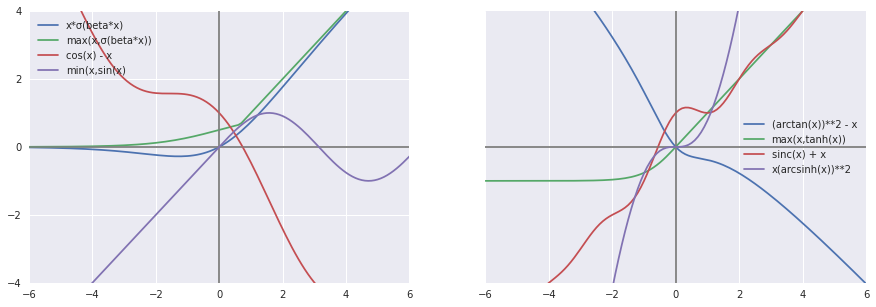

In [4]:
fig,ax = plt.subplots(ncols = 2,figsize = (15,5))
x_values = np.arange(-6,7,0.1,dtype = np.float32)
activations = ['relu',activation_1,activation_2,activation_3,activation_4,activation_5,activation_6,activation_7,activation_8]
fnc_names = [ 'max(x,0)','x*\u03C3(beta*x)','max(x,\u03C3(beta*x))','cos(x) - x','min(x,sin(x)','(arctan(x))**2 - x',
             'max(x,tanh(x))','sinc(x) + x','x(arcsinh(x))**2']

for name,activation in zip(fnc_names[1:5],activations[1:5]):
  y = activation(x_values).numpy()
  ax[0].axhline(0, color = 'gray', alpha = 0.5)
  ax[0].axvline(0, color = 'gray', alpha = 0.5)
  ax[0].plot(x_values,y, label = name)
  ax[0].set_ylim(-4,4)
  ax[0].set_xlim(-6,6)
  ax[0].set_yticks([-4,-2,0,2,4])
  ax[0].legend(loc = 'upper left')
  
for name,activation in zip(fnc_names[5:],activations[5:]):
  y = activation(x_values).numpy()
  ax[1].axhline(0, color = 'gray', alpha = 0.5)
  ax[1].axvline(0, color = 'gray', alpha = 0.5)
  ax[1].plot(x_values,y, label = name)
  ax[1].set_ylim(-4,4)
  ax[1].set_xlim(-6,6)
  ax[1].set_yticks([])
  ax[1].legend(loc = 'center right')

fig.show()

<a id='2'></a>
## 2. Testing the Candidates on a Neural Network Model

### 2.1. Methodology

The experiments in [[1]](https://arxiv.org/abs/1710.05941) were conducted on transfer learning algorithms. Transfer learning algorithms are great; however, from my experiments, they don't perform well when the image size is small. We can resize the images, but the RAM becomes a problem in this case. So instead, I used a smaller image processing model and tested the activation functions on that model. I also replicated the experiment on three different seeds to achieve the actual performances of the activation functions.

**The Data and The Parameters I Used**
* Data: CIFAR - 10
* Epochs : 100
* Batch size: 128
* Optimizer: SGD
* Number of Convolution Layer: 3
* Number of Pooling Layer: 3
* Number of Dense Layer: 2

In [5]:
(x_train,y_train),(x_test,y_test) = keras.datasets.cifar10.load_data()
y_train = y_train.ravel()
y_test = y_test.ravel()

170508288/170498071 [==============================] - 6s 0us/step


In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test))

In [7]:
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

train_ds = train_ds.batch(128)
test_ds = test_ds.batch(128)

2022-08-11 12:57:53.845748: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-11 12:57:54.823309: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-08-11 13:26:55.510536: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:801] layout failed: Invalid argument: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/sequential_7/conv2d_23/SelectV2_1-1-TransposeNHWCToNCHW-LayoutOptimizer


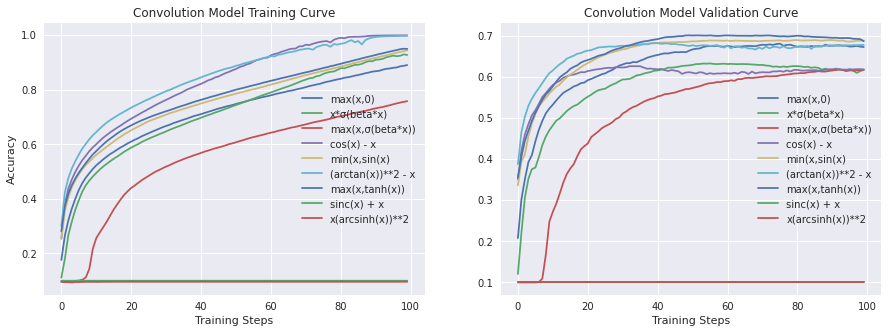

In [8]:
seed(1)
set_random_seed(1)

histories = [] 
for activation in activations:
  history = train_model(activation)
  histories.append(history)
plot_histories(histories)

2022-08-11 14:04:29.800565: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:801] layout failed: Invalid argument: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/sequential_16/conv2d_50/SelectV2_1-1-TransposeNHWCToNCHW-LayoutOptimizer


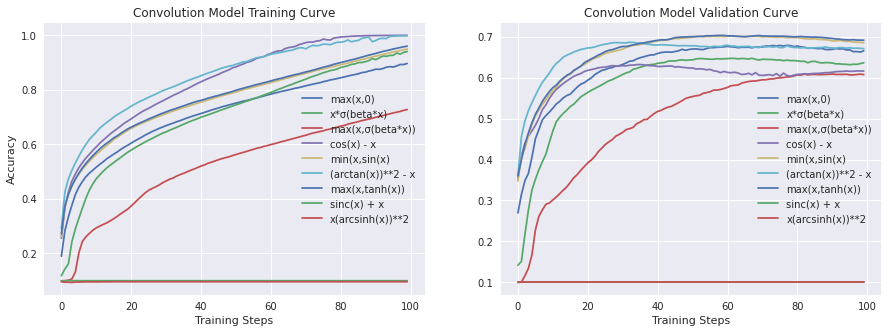

In [9]:
seed(2)
set_random_seed(2)

histories_2 = []
for activation in activations:
  history = train_model(activation)
  histories_2.append(history)
    
plot_histories(histories_2)

2022-08-11 14:42:11.231434: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:801] layout failed: Invalid argument: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/sequential_25/conv2d_77/SelectV2_1-1-TransposeNHWCToNCHW-LayoutOptimizer


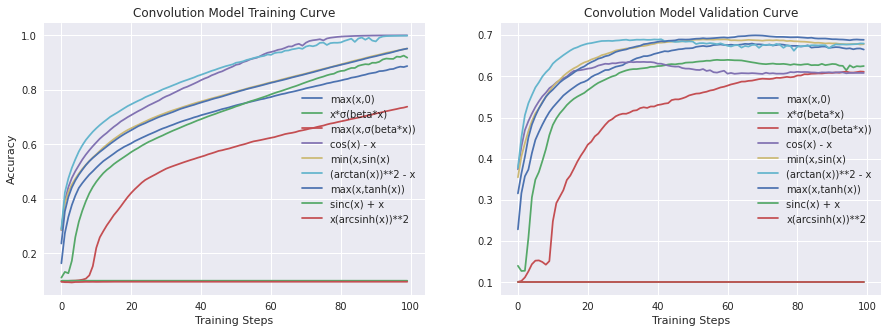

In [10]:
seed(3)
set_random_seed(3)

histories_3 = []
for activation in activations:
  history = train_model(activation)
  histories_3.append(history)
    
plot_histories(histories_3)

### 2.2 The Results and Discussion

* 100 epochs seem too much for some of the activations. Especially "cos(x) - x" and "swish"  were affected negatively from training too much. On the flip side, max(x, swish(x)) benefitted from more  training the most. The rest of the activation functions did not lose their performance yet; the increase in training set performance indicates that overfitting would occur if the models continue to train.

* On training set, (arctan(x))** 2-x improved best at first ~50 epochs. After that, cos(x) - x takes the lead. However, although the best accuracy on the training set is achieved with cos(x) - x as seen from the second graph, its generalization capacity  is significantly lower. 

* The best generalization capacity belongs to max(x,tanh(x)) and the worst one belongs to x(arcsinh(x))^2. But more than that, the model using x(arcsinh(x))^2 has a learning problem.

* The performance of Swish was not the best. ReLU performed better in this experiment. By changing the beta parameter, the performance of Swish may improve.


Hope the experiment was useful. Thanks,

Egemen